<a href="https://colab.research.google.com/github/PhanDuyNhat/AI/blob/Code_AI/Finaltest_Detect_Language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# liên kết với google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

import numpy as np  # Thư viện tính toán số học và đại số tuyến tính
import pandas as pd  # Thư viện xử lý và phân tích dữ liệu dạng bảng
import os  # Thư viện quản lý đường dẫn và hệ điều hành
import seaborn as sns  # Thư viện vẽ đồ thị và trực quan hóa dữ liệu
import matplotlib.pyplot as plt  # Thư viện vẽ đồ thị và biểu đồ
%matplotlib inline  # Dùng để hiển thị đồ thị ngay trên notebook

import cv2  # Thư viện xử lý ảnh

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score  # Thư viện đánh giá mô hình
from sklearn.model_selection import train_test_split  # Thư viện chia tập dữ liệu

import tensorflow as tf  # Thư viện deep learning
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical

from glob import glob  # Thư viện quản lý đường dẫn

import sklearn  # Thư viện chứa các công cụ cho việc huấn luyện và đánh giá mô hình


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp "/content/drive/MyDrive/AI/data/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
cd '/content/drive/MyDrive/AI/data'

/content/drive/MyDrive/AI/data


In [ ]:
ls

asl-alphabet.zip  kaggle.json


In [ ]:
# tai dataset ve drive
! kaggle datasets download -d grassknoted/asl-alphabet

asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:

! unzip 'asl-alphabet.zip'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alpha

In [ ]:
cd '/content/drive/MyDrive/AI/data/asl_alphabet_train/asl_alphabet_train'

/content/drive/MyDrive/AI/data/asl_alphabet_train/asl_alphabet_train


In [ ]:
ls

A/  C/  del/  F/  H/  J/  L/  N/        O/  Q/  S/      T/  V/  X/  Z/
B/  D/  E/    G/  I/  K/  M/  nothing/  P/  R/  space/  U/  W/  Y/


# Data pre-processsing


In [ ]:
train_folder = '/content/drive/MyDrive/AI/data/asl_alphabet_train/asl_alphabet_train'

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

def load_images(train_folder):
    images = []  # Danh sách lưu trữ các ảnh
    labels = []  # Danh sách lưu trữ các nhãn
    index = -1  # Chỉ số cho nhãn

    folders = sorted(os.listdir(train_folder))  # Lấy danh sách thư mục trong  train_folder và sắp xếp

    for folder in folders:
        index += 1  # Tăng chỉ số nhãn

        print("Loading images from folder", folder, "has started.")

        for image in os.listdir(train_folder + '/' + folder):  # Lặp qua từng file ảnh trong thư mục hiện tại
            img = cv2.imread(train_folder + '/' + folder + '/' + image, 0)  # Đọc ảnh dùng OpenCV và chuyển sang ảnh xám
            img = edge_detection(img)  # Áp dụng phát hiện biên cạnh lên ảnh 
            img = cv2.resize(img, (64, 64))  # Thay đổi kích thước ảnh 
            img = img_to_array(img)  # Chuyển đổi ảnh thành mảng numpy
            images.append(img)  # Thêm ảnh vào danh sách images
            labels.append(index)  # Thêm nhãn vào danh sách labels

    images = np.array(images)  # Chuyển danh sách images thành mảng numpy
    images = images.astype('float32') / 255.0  # Chuyển giá trị về khoảng khoảng [0, 1]
    labels = to_categorical(labels)  # Chuyển đổi nhãn thành dạng one-hot encoding

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1)  # Chia dữ liệu thành tập huấn luyện và tập kiểm tra

    return X_train, X_test, y_train, y_test

def edge_detection(image):
    minValue = 70  # Setup giá trị ngưỡng 
    blur = cv2.GaussianBlur(image, (5, 5), 2)  # Làm mờ ảnh 
    th3 = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)  # Áp dụng phân ngưỡng phụ thuộc (adaptive thresholding)
    ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  # Áp dụng phân ngưỡng nhị phân Otsu
    return res  # Trả về ảnh đã qua xử lý biên cạnh


In [ ]:
# Gọi hàm load_images và lưu kết quả trả về vào các biến X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = load_images(train_folder)

Loading images from folder  A  has started.
Loading images from folder  B  has started.
Loading images from folder  C  has started.
Loading images from folder  D  has started.
Loading images from folder  E  has started.
Loading images from folder  F  has started.
Loading images from folder  G  has started.
Loading images from folder  H  has started.
Loading images from folder  I  has started.
Loading images from folder  J  has started.
Loading images from folder  K  has started.
Loading images from folder  L  has started.
Loading images from folder  M  has started.
Loading images from folder  N  has started.
Loading images from folder  O  has started.
Loading images from folder  P  has started.
Loading images from folder  Q  has started.
Loading images from folder  R  has started.
Loading images from folder  S  has started.
Loading images from folder  T  has started.
Loading images from folder  U  has started.
Loading images from folder  V  has started.
Loading images from folder  W  h

In [ ]:

img_width, img_height = 64, 64  # Kích thước ảnh
batch_size = 128  # Số lượng mẫu trong mỗi lần cập nhật gradient
y_col = 'label'  # Tên cột chứa nhãn trong tập dữ liệu
x_col = 'path'  # Tên cột chứa đường dẫn file trong tập dữ liệu

# Tạo  ImageDataGenerator cho dữ liệu để training
train_datagen = ImageDataGenerator(
    rescale=1/255.0,  # chuyển gía trị về khoảng [0, 1]
    zoom_range=0.2,  # Zone zoom ảnh
    width_shift_range=0.2,  # Phạm vi dịch chuyển theo chiều rộng
    height_shift_range=0.2,  # Phạm vi dịch chuyển theo chiều cao
    shear_range=0.2,  # Phạm vi biến dạng cắt ảnh
    horizontal_flip=True,  # Lật ảnh theo chiều ngang
    vertical_flip=False  # Không lật ảnh theo chiều dọc
)

# Tạo một generator cho dữ liệu huấn luyện
train_generator = train_datagen.flow(
    X_train,  # Dữ liệu ảnh huấn luyện
    y_train,  # Nhãn tương ứng với dữ liệu huấn luyện
    batch_size=batch_size,  # Kích thước batch
    shuffle=False  # Giữ nguyên thứ tự
)

# Tạo một đối tượng ImageDataGenerator cho dữ liệu validation
validation_datagen = ImageDataGenerator(rescale=1/255.0)  # Chuyển giá trị về khoảng [0, 1]

# Tạo generator cho dữ liệu validation
validation_generator = validation_datagen.flow(
    X_test,  # Dữ liệu ảnh validation
    y_test,  # Nhãn tương ứng với dữ liệu validation
    batch_size=batch_size,  # Kích thước batch
    shuffle=False  # Giữ nguyên thức tự
)


In [ ]:
# chỉ số lớp (class indices) tới các nhãn tương ứng.
# trường hợp này có 28 lớp từ 0 - 27 
map_characters = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 
                  10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 
                  19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'space'}

# Build CNN model

In [ ]:

model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # Lớp Convolutional 2D với 32 bộ lọc kích thước (3, 3), hàm kích hoạt là ReLU, input_shape là (64, 64, 1)
    layers.MaxPool2D((2, 2)),  # 2x2
    layers.Conv2D(64, (3, 3), activation='relu'),  # 64,3x3
    layers.MaxPool2D((2, 2)),  # 2x2
    layers.Conv2D(64, (3, 3), activation='relu'),  # 64,3x3
    layers.MaxPool2D((2, 2)),  # 2x2
    layers.Flatten(),  # 4D -> 1D
    layers.Dense(256, activation='relu'),  # 256 - relu
    layers.Dense(128, activation='relu'),  # 128 - relu
    layers.Dense(29, activation='softmax')  # 29 -softmax
])

model.summary()  # In thông tin  các lớp và số lượng tham số


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)        

# Train model

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(78214, 64, 64, 1)
(8691, 64, 64, 1)
(78214, 29)
(8691, 29)


In [ ]:
classes = 28  # Số lớp classes
epochs = 20  # Số vòng lặp huấn luyện
learning_rate = 0.0001  # Tốc độ học 

adam = Adam(lr=learning_rate)  # Hàm tốc độ học Adam

# Biên dịch mô hình với biến adam 
# Độ sai lệch là categorical_crossentropy 
# Độ chính xác là accuracy
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(X_train, y_train,  # Dữ liêu đầu vào 
                    epochs=epochs,  # Số vòng lặp 
                    verbose=1,  # Hiển thị tiến trình huấn luyện
                    validation_data=(X_test, y_test),  # Dữ liệu kiểm tra là X_test, y_test
                    shuffle=True)  # Thay đổi thứ tự 



Epoch 1/20
2445/2445 [==============================] - 28s 7ms/step - loss: 0.8097 - accuracy: 0.7501 - val_loss: 0.1503 - val_accuracy: 0.9489
Epoch 2/20
2445/2445 [==============================] - 15s 6ms/step - loss: 0.1102 - accuracy: 0.9627 - val_loss: 0.0813 - val_accuracy: 0.9720
Epoch 3/20
2445/2445 [==============================] - 16s 6ms/step - loss: 0.0610 - accuracy: 0.9808 - val_loss: 0.0778 - val_accuracy: 0.9764
Epoch 4/20
2445/2445 [==============================] - 15s 6ms/step - loss: 0.0447 - accuracy: 0.9858 - val_loss: 0.1049 - val_accuracy: 0.9665
Epoch 5/20
2445/2445 [==============================] - 15s 6ms/step - loss: 0.0318 - accuracy: 0.9901 - val_loss: 0.0603 - val_accuracy: 0.9806
Epoch 6/20
2445/2445 [==============================] - 16s 6ms/step - loss: 0.0314 - accuracy: 0.9901 - val_loss: 0.0202 - val_accuracy: 0.9926
Epoch 7/20
2445/2445 [==============================] - 16s 6ms/step - loss: 0.0235 - accuracy: 0.9927 - val_loss: 0.0250 - val_ac

In [ ]:
model.save("/content/drive/MyDrive/AI/data/models/detectlanguage.hdf5")  
# Lưu  HDF5 file 'detectlanguage.hdf5'



# Evaluate

2445/2445 [==============================] - 10s 4ms/step - loss: 0.0046 - accuracy: 0.9985
Loss: 0.004598645027726889
Accuracy: 0.9984529614448547


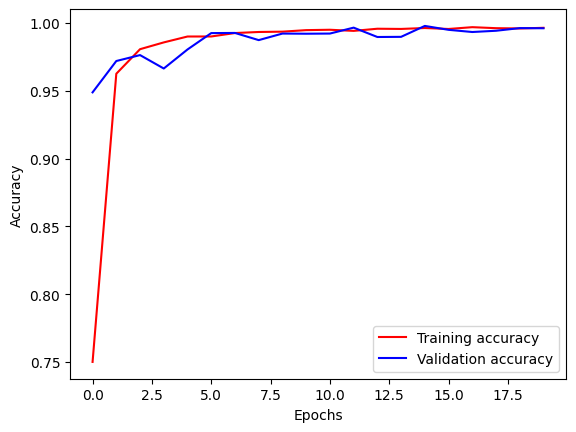

In [ ]:
# Đánh giá mô hình trên dữ liệu kiểm tra và lưu giá trị độ sai lệch và độ chính xác
score = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy_val = model.evaluate(X_test, y_test)
a, b = model.evaluate(X_train, y_train)

print("Loss:", a)
print("Accuracy:", b)


# Lấy giá trị độ chính xác 
accuracy = history.history['accuracy']
epochs = range(len(accuracy))

#Vẽ đồ thị độ chính xác training theo số vòng lặp
plt.plot(epochs, accuracy, 'r-', label='Training accuracy')
val_accuracy = history.history['val_accuracy']  

#Vẽ đồ thị độ chính xác testing theo số vòng lặp
plt.plot(epochs, val_accuracy, 'b-', label='Validation accuracy')  

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()